# 

# Flow Matching


In [148]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [149]:
class VelocityField(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(VelocityField, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    # predict velocity field at time t for input x_t
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        # concatenate time with input: (B, 1) and (B, D) -> (B, D+1)
        return self.net(torch.cat([t, x_t], dim=-1))
    
    # step the flow forward for sampling at time t
    def step(self, x_t: Tensor, ts: Tensor, te: float) -> Tensor:
        # x_t: (N, D)
        # t: (1,)
        # dt: scalar time step size
        ts = ts.view(1, 1).expand(x_t.size(0), 1)  # (N, 1)

        # euler method for ODE solver
        # x_t = x_t + dt * f(x_t, t)
        x_t = x_t + (te - ts) * self(x_t, ts)
        
        # midpoint rule for ODE solver
        #x_t = x_t + (te - ts) * self(x_t + self(x_t, ts) * (te - ts) / 2, ts + (te - ts) / 2)
        return x_t

In [161]:
# training
vf = VelocityField(input_dim=2, hidden_dim=64)
optimizer = torch.optim.Adam(vf.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

epochs = 10000
batch_size = 256
for _ in range(epochs):
    # generate data
    x_1 = Tensor(make_moons(n_samples=batch_size, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    
    # sample time uniformly
    t = torch.rand(batch_size, 1) 
    
    # sample x_t
    x_t = x_0 + (x_1 - x_0) * t
    dx_t = x_1 - x_0 
    
    # trainging step
    optimizer.zero_grad()
    loss = loss_fn(vf(x_t, t), dx_t)
    loss.backward()
    optimizer.step()
    
    # print progress
    if _ % 100 == 0:
        print(f'Epoch {_}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.7387
Epoch 100, Loss: 1.0346
Epoch 200, Loss: 1.0708
Epoch 300, Loss: 1.0393
Epoch 400, Loss: 0.9973
Epoch 500, Loss: 0.9043
Epoch 600, Loss: 1.1741
Epoch 700, Loss: 0.9255
Epoch 800, Loss: 0.9882
Epoch 900, Loss: 1.0027
Epoch 1000, Loss: 1.0104
Epoch 1100, Loss: 1.0212
Epoch 1200, Loss: 0.9967
Epoch 1300, Loss: 1.0587
Epoch 1400, Loss: 1.0098
Epoch 1500, Loss: 0.9608
Epoch 1600, Loss: 0.9640
Epoch 1700, Loss: 0.9095
Epoch 1800, Loss: 1.1553
Epoch 1900, Loss: 1.0105
Epoch 2000, Loss: 1.0260
Epoch 2100, Loss: 0.9513
Epoch 2200, Loss: 1.0265
Epoch 2300, Loss: 0.9771
Epoch 2400, Loss: 0.9843
Epoch 2500, Loss: 1.0795
Epoch 2600, Loss: 1.0687
Epoch 2700, Loss: 1.0379
Epoch 2800, Loss: 0.9894
Epoch 2900, Loss: 0.9808
Epoch 3000, Loss: 0.9943
Epoch 3100, Loss: 0.7696
Epoch 3200, Loss: 0.9175
Epoch 3300, Loss: 1.1787
Epoch 3400, Loss: 0.9655
Epoch 3500, Loss: 1.0494
Epoch 3600, Loss: 0.8905
Epoch 3700, Loss: 0.9955
Epoch 3800, Loss: 0.9850
Epoch 3900, Loss: 0.8794
Epoch 4000, 

In [186]:
# Sampling after training
x = torch.randn(300, 2)  # initial points'
n_steps = 8
time_steps = torch.linspace(0, 1., n_steps+1)


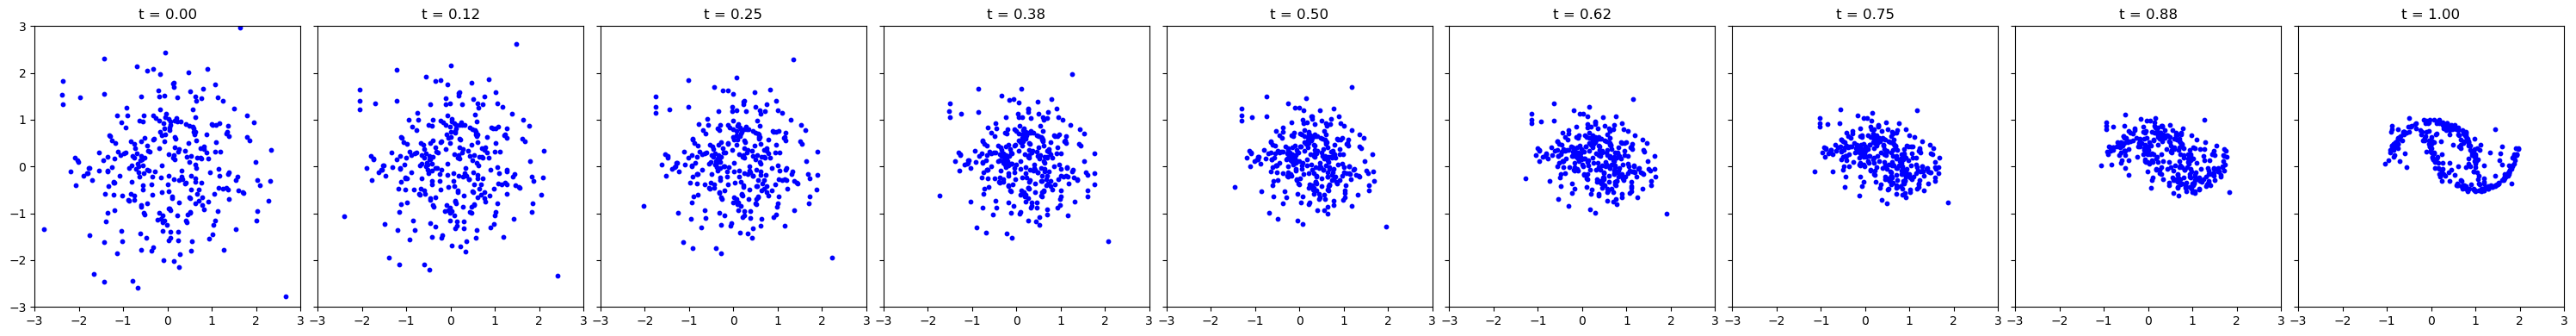

In [187]:
fig, axes = plt.subplots(1, n_steps+1, figsize=(30, 4), sharex=True, sharey=True)
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10, color='blue')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)

for i in range(n_steps):
    x = vf.step(x_t=x, ts=time_steps[i], te=time_steps[i+1])
    axes[i+1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10, color='blue')
    axes[i+1].set_title(f't = {time_steps[i+1]:.2f}')
plt.tight_layout()
plt.show()

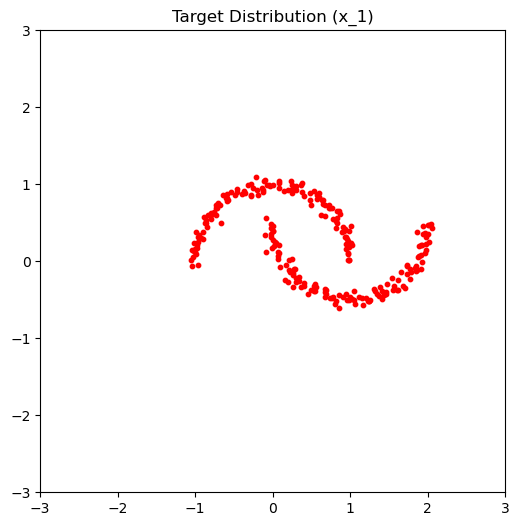

In [188]:
# print x1
plt.figure(figsize=(6, 6))
plt.scatter(x_1.detach()[:, 0], x_1.detach()[:, 1], s=10, color='red')
plt.title('Target Distribution (x_1)')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()